In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Check if CUDA is available and use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_paths = []
        self.labels = []
        
        class_names = os.listdir(image_dir)
        self.class_map = {class_name: idx for idx, class_name in enumerate(class_names)}
        
        for class_name in class_names:
            class_folder = os.path.join(image_dir, class_name)
            for img_name in os.listdir(class_folder):
                self.image_paths.append(os.path.join(class_folder, img_name))
                self.labels.append(self.class_map[class_name])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # Resize to 224x224, as CNN models typically expect this input size
        
        label = self.labels[idx]
        
        # Convert the image to tensor directly without transforms
        img = torch.tensor(img).float()
        img = img.permute(2, 0, 1)  # Change shape from HWC to CHW format
        
        return img, label

In [9]:
# Load datasets
train_dir = '../Codes/berry/Train'  # Path to your training data folder
test_dir = '../Codes/berry/Test'  # Path to your test data folder

In [10]:
train_dataset = PlantDiseaseDataset(train_dir)
test_dataset = PlantDiseaseDataset(test_dir)

Training class distribution: Counter({0: 700, 1: 700, 2: 700, 3: 700, 4: 700, 5: 700, 6: 700})
Test class distribution: Counter({0: 80, 1: 80, 2: 80, 3: 80, 4: 80, 5: 80, 6: 80})


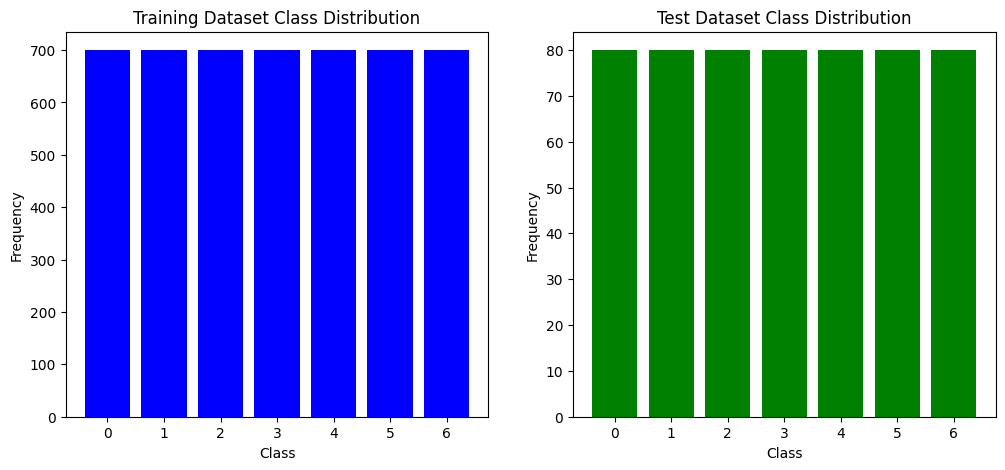

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

# Check class distribution in the training dataset
train_labels = [label for _, label in train_dataset]
train_class_counts = Counter(train_labels)
print("Training class distribution:", train_class_counts)

# Check class distribution in the test dataset
test_labels = [label for _, label in test_dataset]
test_class_counts = Counter(test_labels)
print("Test class distribution:", test_class_counts)

# Plotting the class distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training dataset distribution
ax[0].bar(train_class_counts.keys(), train_class_counts.values(), color='blue')
ax[0].set_title('Training Dataset Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')

# Test dataset distribution
ax[1].bar(test_class_counts.keys(), test_class_counts.values(), color='green')
ax[1].set_title('Test Dataset Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')

plt.show()

In [12]:
# Display class names with class numbers
class_names = train_dataset.class_map
for class_name, class_number in class_names.items():
    print(f"Class Name: {class_name}, Class Number: {class_number}")

Class Name: angular_leafspot, Class Number: 0
Class Name: anthracnose_fruit_rot, Class Number: 1
Class Name: blossom_blight, Class Number: 2
Class Name: gray_mold94, Class Number: 3
Class Name: leaf_spot, Class Number: 4
Class Name: powdery_mildew_fruit, Class Number: 5
Class Name: powdery_mildew_leaf, Class Number: 6


In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
# Define improved custom CNN architecture
class CustomCNN(nn.Module):
    def __init__(self, num_classes=7):  # Updated to 5 classes
        super(CustomCNN, self).__init__()
        
        # Define the layers of the custom CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.conv6 = nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(2048)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(2048 * 3 * 3, 4096)  # Adjusted input size
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, num_classes)  # Updated to 5 classes
        
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = self.pool(torch.relu(self.bn5(self.conv5(x))))
        x = self.pool(torch.relu(self.bn6(self.conv6(x))))
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x


In [15]:
# Initialize the model, loss function, and optimizer
model = CustomCNN(num_classes=7)
model = model.to(device)

In [16]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [17]:
# Updated training loop to store loss and accuracy


# Debugging code to check labels and model output dimensions
def train_model_debug(model, train_loader, criterion, optimizer, num_epochs=10):
	model.train()
	train_loss = []
	train_accuracy = []
	
	for epoch in range(num_epochs):
		running_loss = 0.0
		correct_predictions = 0
		total_predictions = 0
		
		for inputs, labels in train_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			
			# Check if labels are within the correct range
			if labels.max() >= model.fc4.out_features:
				raise ValueError(f"Label value {labels.max()} is out of range for the number of classes {model.fc4.out_features}")
			
			optimizer.zero_grad()
			outputs = model(inputs)
			
			# Check the output dimensions
			if outputs.size(1) != model.fc4.out_features:
				raise ValueError(f"Output dimension {outputs.size(1)} does not match the number of classes {model.fc4.out_features}")
			
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			
			running_loss += loss.item()
			
			_, predicted = torch.max(outputs, 1)
			correct_predictions += (predicted == labels).sum().item()
			total_predictions += labels.size(0)
		
		epoch_loss = running_loss / len(train_loader)
		epoch_accuracy = 100 * correct_predictions / total_predictions
		train_loss.append(epoch_loss)
		train_accuracy.append(epoch_accuracy)
		print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
	
	print("Training finished!")
	return train_loss, train_accuracy


In [18]:

# Train the model and get the loss and accuracy values
train_loss, train_accuracy = train_model_debug(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 0.9194, Accuracy: 64.59%
Epoch [2/10], Loss: 0.5370, Accuracy: 80.98%
Epoch [3/10], Loss: 0.3890, Accuracy: 85.51%
Epoch [4/10], Loss: 0.3203, Accuracy: 88.57%
Epoch [5/10], Loss: 0.2732, Accuracy: 90.51%
Epoch [6/10], Loss: 0.2011, Accuracy: 93.08%
Epoch [7/10], Loss: 0.1825, Accuracy: 93.92%
Epoch [8/10], Loss: 0.1429, Accuracy: 95.14%
Epoch [9/10], Loss: 0.1475, Accuracy: 95.43%
Epoch [10/10], Loss: 0.1277, Accuracy: 95.98%
Training finished!


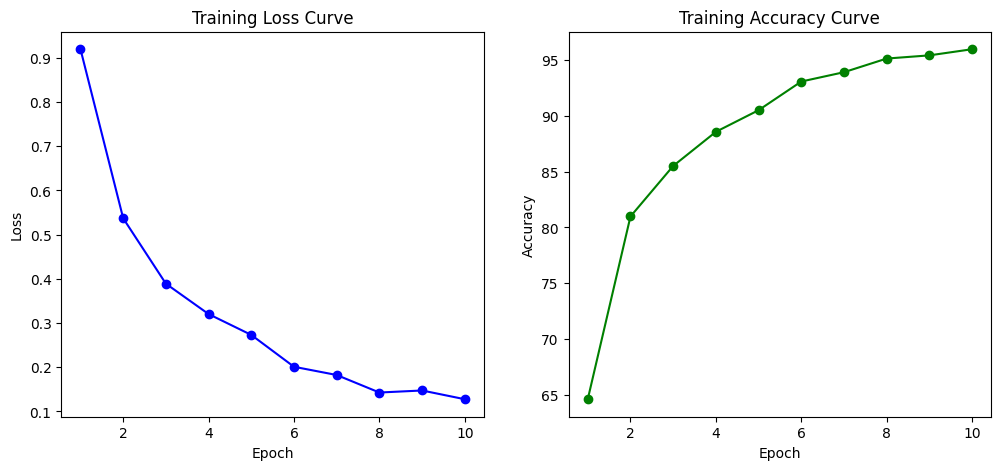

In [19]:

# Plotting the loss and accuracy curves
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss curve
ax[0].plot(range(1, len(train_loss) + 1), train_loss, marker='o', color='blue')
ax[0].set_title('Training Loss Curve')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

# Accuracy curve
ax[1].plot(range(1, len(train_accuracy) + 1), train_accuracy, marker='o', color='green')
ax[1].set_title('Training Accuracy Curve')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

plt.show()

In [22]:
# Evaluate model
import numpy as np

def evaluate_model(model, test_loader):
    model.eval()
    true_labels = []
    predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
    
    print("Classification Report:")
    print(classification_report(true_labels, predictions, target_names=list(class_names.keys())))
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))  # Dynamically set the range based on class_names
    plt.xticks(tick_marks, list(class_names.keys()), rotation=45)
    plt.yticks(tick_marks, list(class_names.keys()))
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Classification Report:
                       precision    recall  f1-score   support

     angular_leafspot       0.98      1.00      0.99        80
anthracnose_fruit_rot       0.89      0.88      0.88        80
       blossom_blight       1.00      0.95      0.97        80
          gray_mold94       0.70      0.95      0.80        80
            leaf_spot       1.00      0.97      0.99        80
 powdery_mildew_fruit       0.95      0.66      0.78        80
  powdery_mildew_leaf       0.97      0.97      0.97        80

             accuracy                           0.91       560
            macro avg       0.93      0.91      0.91       560
         weighted avg       0.93      0.91      0.91       560



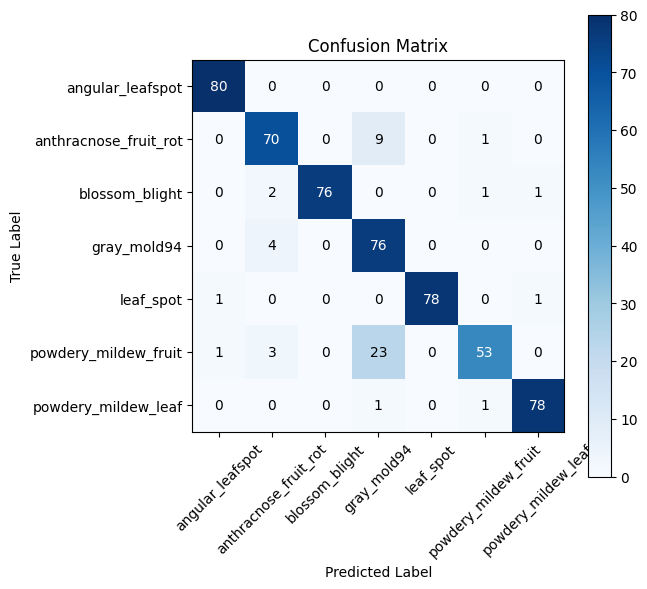

In [23]:
# Evaluate the model
evaluate_model(model, test_loader)

In [24]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'strawbery_disease_model.pth')
print("Model saved successfully!")

Model saved successfully!


Classification Report:
                       precision    recall  f1-score   support

     angular_leafspot       0.98      1.00      0.99        80
anthracnose_fruit_rot       0.89      0.88      0.88        80
       blossom_blight       1.00      0.95      0.97        80
          gray_mold94       0.70      0.95      0.80        80
            leaf_spot       1.00      0.97      0.99        80
 powdery_mildew_fruit       0.95      0.66      0.78        80
  powdery_mildew_leaf       0.97      0.97      0.97        80

             accuracy                           0.91       560
            macro avg       0.93      0.91      0.91       560
         weighted avg       0.93      0.91      0.91       560



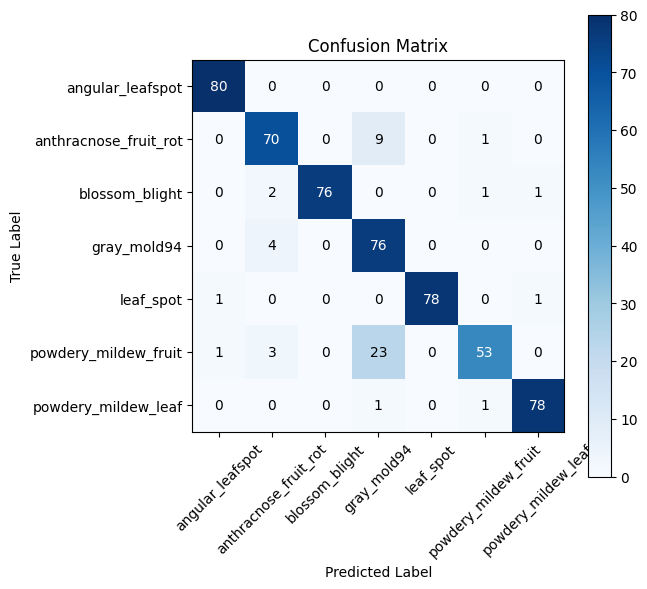

In [26]:
# Define the path to the new set of images
new_test_dir = '../Codes/berry/Test/'  # Path to your new test data folder

# Create a new dataset and dataloader for the new set of images
new_test_dataset = PlantDiseaseDataset(new_test_dir)
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the new set of images
evaluate_model(model, new_test_loader)